In [1]:
import os
if 'note' in os.getcwd(): os.chdir('../..')
print(os.getcwd())

import warnings
warnings.filterwarnings('ignore')

/home/bernie40916/Nas/home/Project/DJtransGAN


In [2]:
import torch
import matplotlib.pyplot as plt

from djtransgan.config          import settings
from djtransgan.utils.noise     import generate_noise
from djtransgan.utils.visualize import wave_visualize, mask_visualize
from djtransgan.mixer.mask      import VMask, HMask
from djtransgan.frontend.utils  import get_amp2db_func, get_stft_func

## Preparation 

In [3]:
stft_func   = get_stft_func()
amp2db_func = get_amp2db_func()

STFT kernels created, time used = 0.1602 seconds


## VMask

### Data Prepareing

In [4]:
num_band     = 3 
num_param    = 2 # each eq has two parameters (Cutoff_freq, Q_factor)
batch_size   = 4 

waves        = torch.stack([generate_noise(10).unsqueeze(0) for batch in range(batch_size)]) # (batch_size, channels, samples)
mags, phases = stft_func(waves) # (batch_size, channels, bins, frames)

print('mags: ', mags.size())

mags:  torch.Size([4, 1, 1025, 862])


### VMask Usage

In [5]:
vmask   = VMask('mean', 'low', 'linear', 'equal')
params  = torch.rand(batch_size, num_band - 1, num_param)
vmags, vmasks, vcurves, vfcurves = vmask(mags, params)

print('mag : ', vmags.size())
print('mask: ', vmasks.size())
print('curve: ', vcurves.size())

mag :  torch.Size([4, 3, 1, 1025, 862])
mask:  torch.Size([4, 3, 1, 1025, 862])
curve:  torch.Size([4, 3, 1, 1025])


### VMask Visualize

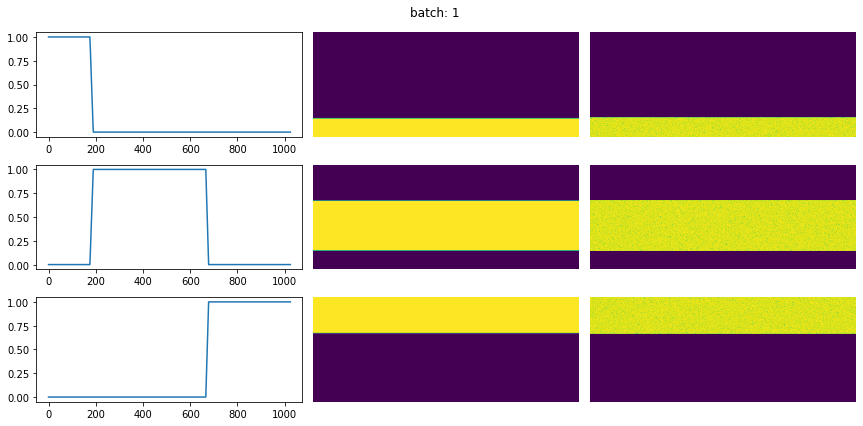

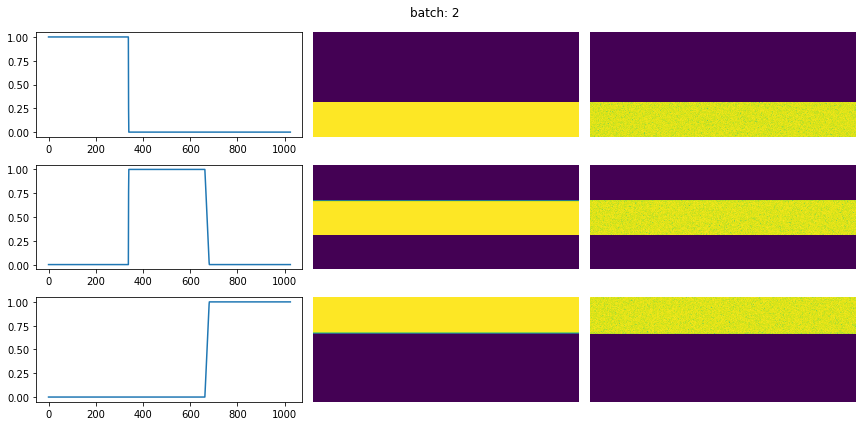

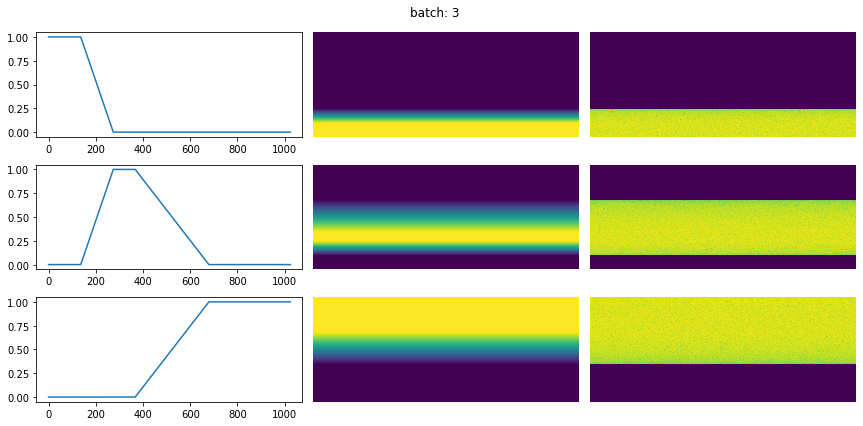

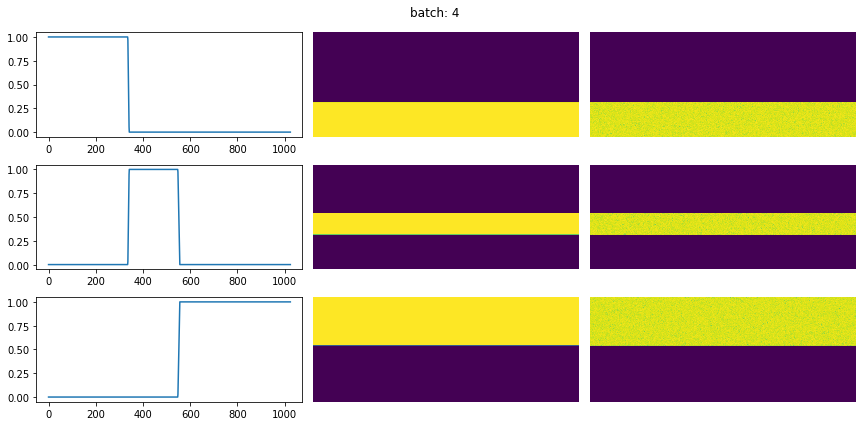

In [6]:
for batch_idx in range(batch_size):
    fig, axes = plt.subplots(num_band, 3, figsize=(12, 6))
    for (mag, mask, curve, ax) in zip(vmags[batch_idx], vmasks[batch_idx], vcurves[batch_idx], axes):
        ax[0].plot(curve[0])
        mask_visualize(mask[0], ax[1])
        mask_visualize(amp2db_func(mag[0]), ax[2])
    plt.suptitle(f'batch: {batch_idx + 1}')
    plt.tight_layout()
    plt.show()

### Check Differentiability

In [7]:
params  = torch.rand(batch_size, num_band - 1, num_param, requires_grad=True)
vmags, vmasks, vcurves, vfcurves = vmask(mags, params)
vmags.backward(torch.ones_like(vmags))
print(f'grad: {params.grad is not None}')

grad: True


## HMask

### Data Prepareing

In [8]:
num_band     = 2
num_fader    = 1
num_param    = 2 # each fader curve need two parameters (start, slope)
batch_size   = 4 
waves        = torch.stack([generate_noise(10).unsqueeze(0) for batch in range(batch_size)])
mags, phases = stft_func(waves)
mags         = torch.stack([mags for i in range(num_band)], axis=1) # (batch_size, bands, channels, bins, frames)

print('mags: ', mags.size())

mags:  torch.Size([4, 2, 1, 1025, 862])


### HMask Usage

In [10]:
hmask   = HMask('sum', 'fi', 'linear')
params  = torch.rand(batch_size, num_band, num_fader, num_param)
hmags, hmasks, hcurves = hmask(mags, params)


print('mag : ', hmags.size())
print('mask: ', hmasks.size())
print('curve: ', hcurves.size())

mag :  torch.Size([4, 2, 1, 1025, 862])
mask:  torch.Size([4, 2, 1, 1025, 862])
curve:  torch.Size([4, 2, 1, 862])


### HMask Visualize

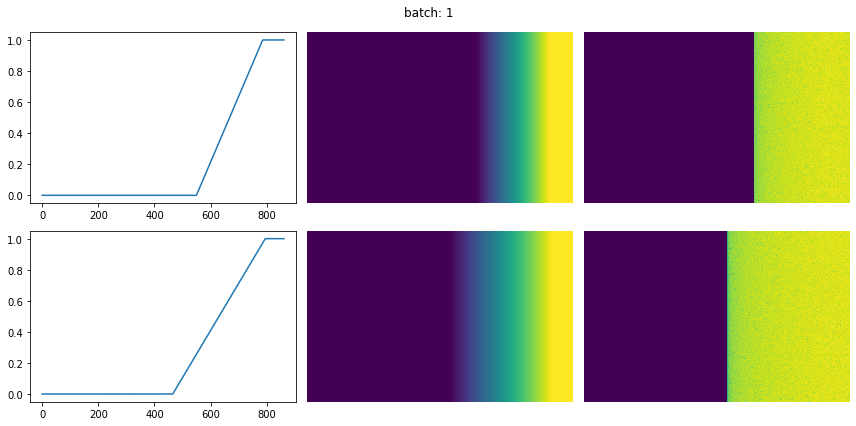

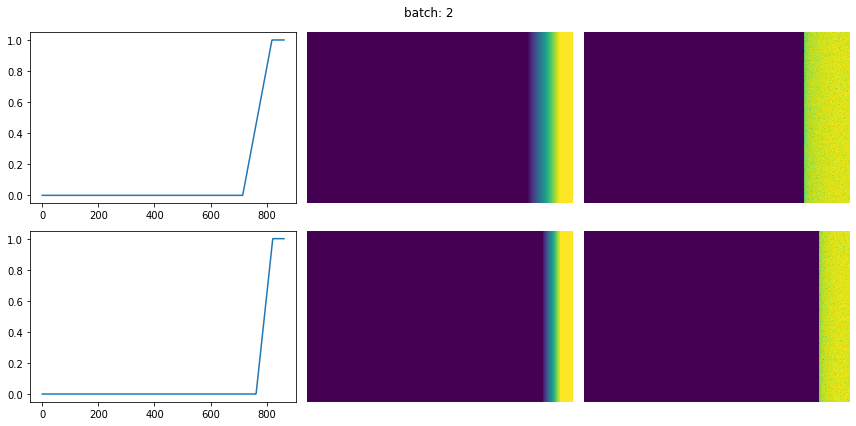

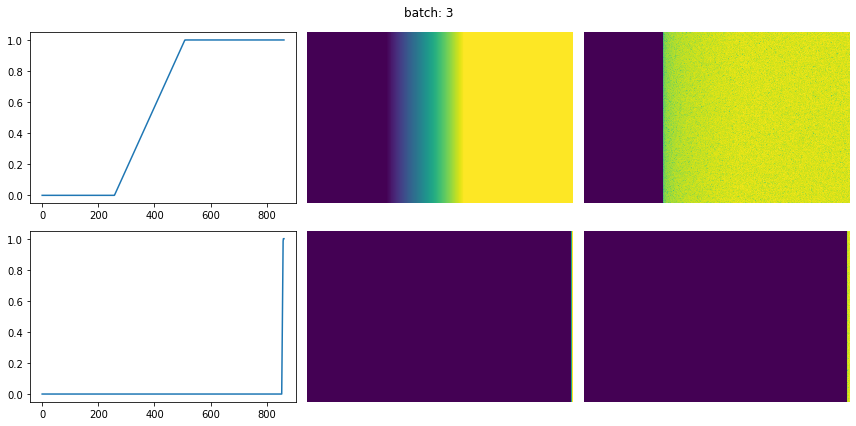

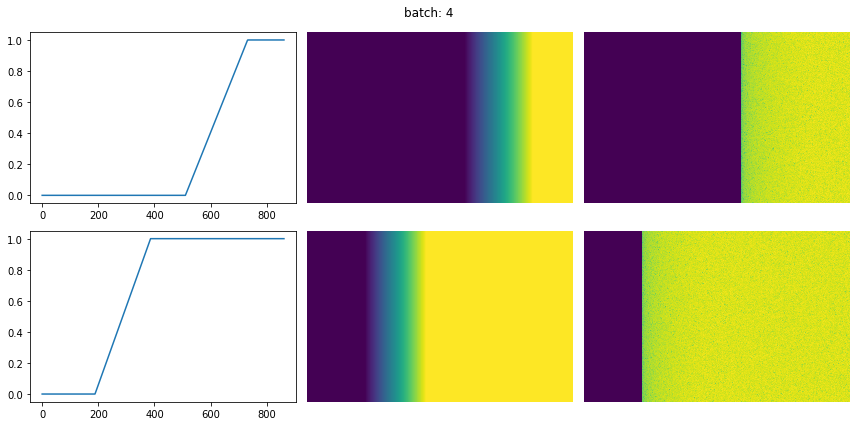

In [11]:
for batch_idx in range(batch_size):
    fig, axes = plt.subplots(num_band, 3, figsize=(12, 6))
    for (mag, mask, curve, ax) in zip(hmags[batch_idx], hmasks[batch_idx], hcurves[batch_idx], axes):
        ax[0].plot(curve[0])
        mask_visualize(mask[0], ax[1])
        mask_visualize(amp2db_func(mag[0]), ax[2])
    plt.suptitle(f'batch: {batch_idx+1}')
    plt.tight_layout()
    plt.show()

### Check Differentiability

In [12]:
params  = torch.rand(batch_size, num_band, num_fader, num_param, requires_grad=True)
hmags, hmasks, hcurves = hmask(mags, params)
hmags.backward(torch.ones_like(hmags))

print(f'grad: {params.grad is not None}')

grad: True
